## 1. Load Libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 2. Load Data

I am using FanGraphs' hitters dataset from their leaderboards tool. All data was accumulated between Opening Day and the morning of June 25, 2025. This data is compiled by FanGraphs and Baseball Savant and is publicly available online for free. This dataset contains 160 observations with 69 features. Columns include counting stats, expected stats, rate stats, and more.

In [7]:
df = pd.read_csv("2025_fg_leaderboard.csv")

## 3. Clean Data

Converting all percentage stats into floating numbers in order to proceed. 

In [8]:
percent_cols = ['Barrel%', 'BB%', 'K%', 'HardHit%', 'Pull%', 'HR/FB']
for col in percent_cols:
    df[col] = df[col].str.rstrip('%').astype(float) / 100

## 4. Feature and Target Selection

For feature selection, I am choosing a variety of features that would likely have a greater effect on fWAR (FanGraphs' calculation of wins above replacement). I am using my existing knowledge of baseball and baseball analytics to figure out which features I should be using. I decided it was important to select only six features; even though each of the 60+ features in this dataset has some bearing on fWAR, it would not have been reasonable to select that many features. Instead, I selected the 6 that I thought (using my own baseball knowledge) would have the greatest impact on fWAR calculation.

Upon selecting the features, I noticed that most of them are associated with quality contact, and power in particular. I have no baserunning metrics, as well as no defensive metrics. While I think this is acceptable because it is well-known that fWAR primarily considers hitting performance, it is a factor to consider.

Importantly, all players in this dataset are "qualified" (they meet MLB's playing time requirement to be statistically relevant), which means I am less likely to have fluky outliers, such as a player who only had one at-bat and managed to hit a home run with a low exit velocity.

In [20]:
features = ['Barrel%', 'EV', 'LA', 'BB%', 'K%', 'HardHit%', 'Pull%', 'HR/FB']
target = 'WAR'

df_clean = df[features + [target]].dropna()


## 5. Normalize, Train, and Test

In [9]:
X = df_clean[features].values
y = df_clean[target].values

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

## 6. Initialize Gradient Boosting Regressor

In [11]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

## 7. Evaluate

In [19]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
r = r2 ** (1/2)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R: {r:.2f}")
print(f"R^2: {r2:.2f}")


RMSE: 1.06
MAE: 0.77
R: 0.45
R^2: 0.20


The results of this were quite underwhelming, as I felt as though I had selected appropriate features to obtain a relationship between actual and predicted fWAR. 

The R^2 value of 0.20 means that only 20% of the variation in home run totals among players can be explained by the model's input features.

If I were to attempt this exploration again, I would probably keep 1-2 of the existing features and find ~6 new features for a total of 7-8 features. Hopefully (even if it requires trial and error) I would be able to get the R^2 above 0.70; I know it's possible because fWAR is a formula containing numerous individual statistics.

## 8. Actual vs. Predicted Visualization

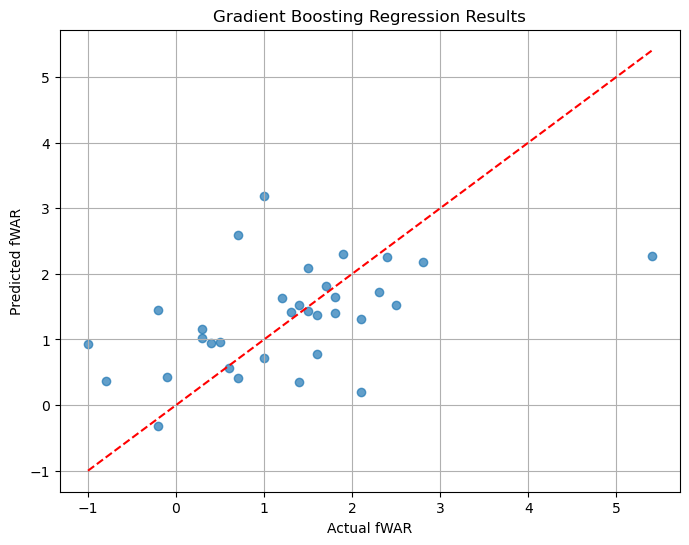

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual fWAR")
plt.ylabel("Predicted fWAR")
plt.title("Gradient Boosting Regression Results")
plt.grid(True)
plt.show()


This scatterplot compares actual fWAR to the predicted fWAR from my gradient boosting regressor model. Included within the plot is a line of best fit (dashed red line) which shows a perfect fit of actual vs. predicted. In other words, if every fWAR total was predicted correctly by the decision tree model, every blue plotted point would fall exactly along the red dashed line.

Although my 0.20 R^2 score was underwhelming, I am pleased to see even a slight relationship between the actual and predicted values on this scatterplot. It's not a great relationship, but I can vaguely see a trend of actual fWAR increasing as predicted fWAR increases, etc. 

## 9. Residuals

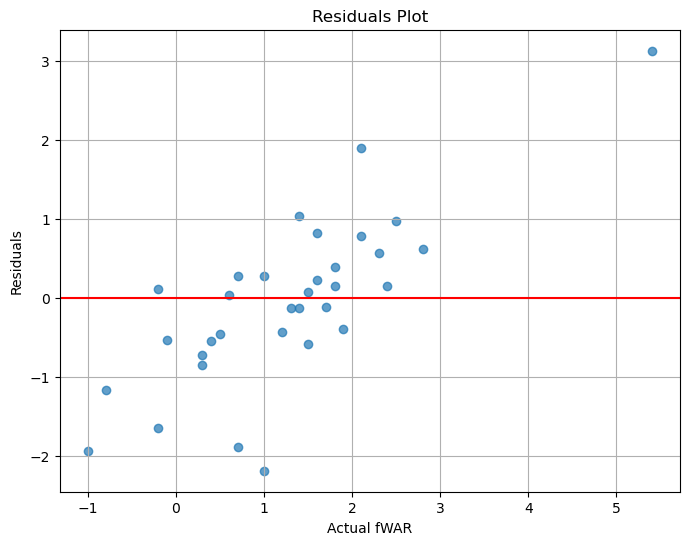

In [16]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(0, color='red')
plt.xlabel("Actual fWAR")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.grid(True)
plt.show()

The above visual shows the residuals for my exploration into fWAR totals. In other words, it plots the difference between actual and predicted fWAR totals among qualified MLB players. This plot does not really show the residuals randomly scattered around 0, as desired. Instead, we see that there are more residuals below 0 and when fWAR is less than 1.5, and more residuals above 0 when fWAR is greater than 1.5. There also appears to be an extreme outlier for a player with ~5.5 fWAR. 

## 10. Performance Evaluation

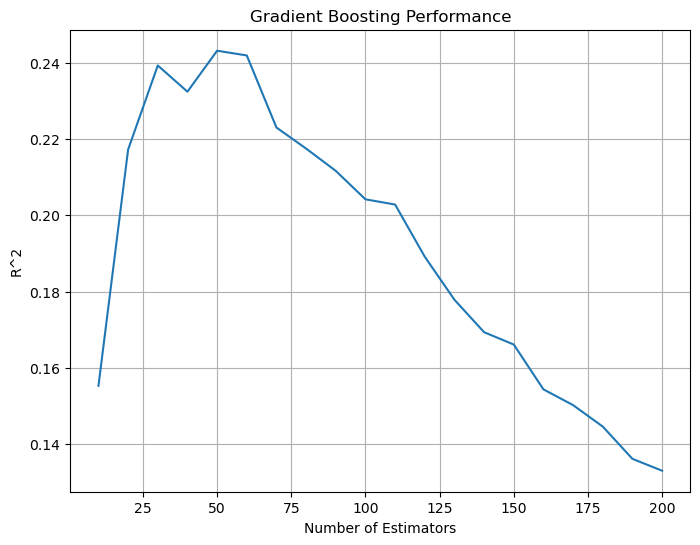

In [18]:
estimator_range = range(10, 201, 10)
r2_scores = []

for n in estimator_range:
    model = GradientBoostingRegressor(n_estimators=n, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2_scores.append(r2_score(y_test, preds))

plt.figure(figsize=(8, 6))
plt.plot(estimator_range, r2_scores)
plt.xlabel("Number of Estimators")
plt.ylabel("R^2")
plt.title("Gradient Boosting Performance")
plt.grid(True)
plt.show()

The R^2 score increases quickly at the start, peaking around 50 estimators. This means that 50 estimators is the point where optimal performance is achieved. 

After 50 estimators, the R^2 score gradually declines, which suggests overfitting, meaning that the model continues to fit the training data more closely but sacrifices quality of performance on the test set.